In [6]:
import spikeinterface.full as si
from probeinterface.plotting import plot_probe, plot_probegroup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from scipy import stats
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap
import os
from P3_CurrentAnalysis.LDM.cebra_helper import extract_fr_column
from Helpers import plot_utility
from P2_PostProcess.VirtualReality.plotting import get_vmin_vmax, min_max_normalize
from P2_PostProcess.VirtualReality.spatial_information import calculate_spatial_information

In [2]:
def get_data(vr_session_base_names, of_session_base_names):
    project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"
    
    master_data = pd.DataFrame()
    for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
        mouse = vr_name.split("_")[0]
        day = vr_name.split("_")[1]
        vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
        of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
        sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
        spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
        spike_data_of = pd.read_pickle(of_path); spike_data_of["firing_times_of"] = spike_data_of["firing_times"]
        spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

        sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
        ulc = sorting_analyzer.get_extension("unit_locations")
        unit_locations = ulc.get_data(outputs="by_unit")
        spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
        spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
        spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])

        position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
        processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
        position_data = pd.read_csv(position_path)
        processed_position_data = pd.read_pickle(processed_position_path)

        spike_data = spike_data[(spike_data["snr_x"] > 1) & 
                                (spike_data["mean_firing_rate_x"] > 0.5) & 
                                (spike_data["rp_contamination_x"] < 0.9)]
        master_data = pd.concat([master_data, spike_data],ignore_index=True)
    return master_data

In [10]:

def remove_3d_axis_junk(ax):
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)); ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)); ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)); ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)); ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

In [14]:
def plot_dimensionality_reductions(spike_data, column, col_column=None):
    neural_space = extract_fr_column(spike_data, column=column)

    # flip axis so its in form (n_samples, n_features)
    neural_space = np.transpose(neural_space)

    # Standardize the data
    scaler = StandardScaler(with_std=False)
    X_standardized = scaler.fit_transform(neural_space)

    # Initialize PCA, t-SNE, UMAP, and Isomap
    pca = PCA(n_components=3)
    tsne = TSNE(n_components=3, random_state=0, perplexity=5)
    reducer = umap.UMAP(n_components=3)
    isomap = Isomap(n_components=3)

    # Fit and transform the data
    X_pca = pca.fit_transform(X_standardized)
    X_tsne = tsne.fit_transform(X_standardized)
    X_umap = reducer.fit_transform(X_standardized)
    X_isomap = isomap.fit_transform(X_standardized)
    X_pca_then_umap = reducer.fit_transform(X_pca)

    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(3, 5, figsize=(15, 9), subplot_kw={'projection': '3d'})
    for i, ldm in enumerate([X_pca, X_tsne, X_umap, X_isomap, X_pca_then_umap]):
        axs[0, i].scatter(ldm[:, 0], ldm[:, 1], ldm[:, 2], c="grey", alpha=0.1)
        axs[1, i].scatter(ldm[:, 0], ldm[:, 1], ldm[:, 2], c="grey", alpha=0.1)
        axs[2, i].scatter(ldm[:, 0], ldm[:, 1], ldm[:, 2], c="grey", alpha=0.1)
        axs[0, i].view_init(elev=0, azim=0)
        axs[1, i].view_init(elev=30, azim=45)
        axs[2, i].view_init(elev=60, azim=30)
        remove_3d_axis_junk(axs[0, i])
        remove_3d_axis_junk(axs[1, i])
        remove_3d_axis_junk(axs[2, i])
    plt.tight_layout()
    plt.show()


In [ ]:
column="fr_time_binned_smoothed"
column="fr_time_binned_bin_centres"
column="ls_powers" 

In [4]:
spike_data = get_data(vr_session_base_names =["M21_D26_2024-05-28_17-04-41_VR1"],
                      of_session_base_names = ["M21_D26_2024-05-28_16-35-31_OF1"])

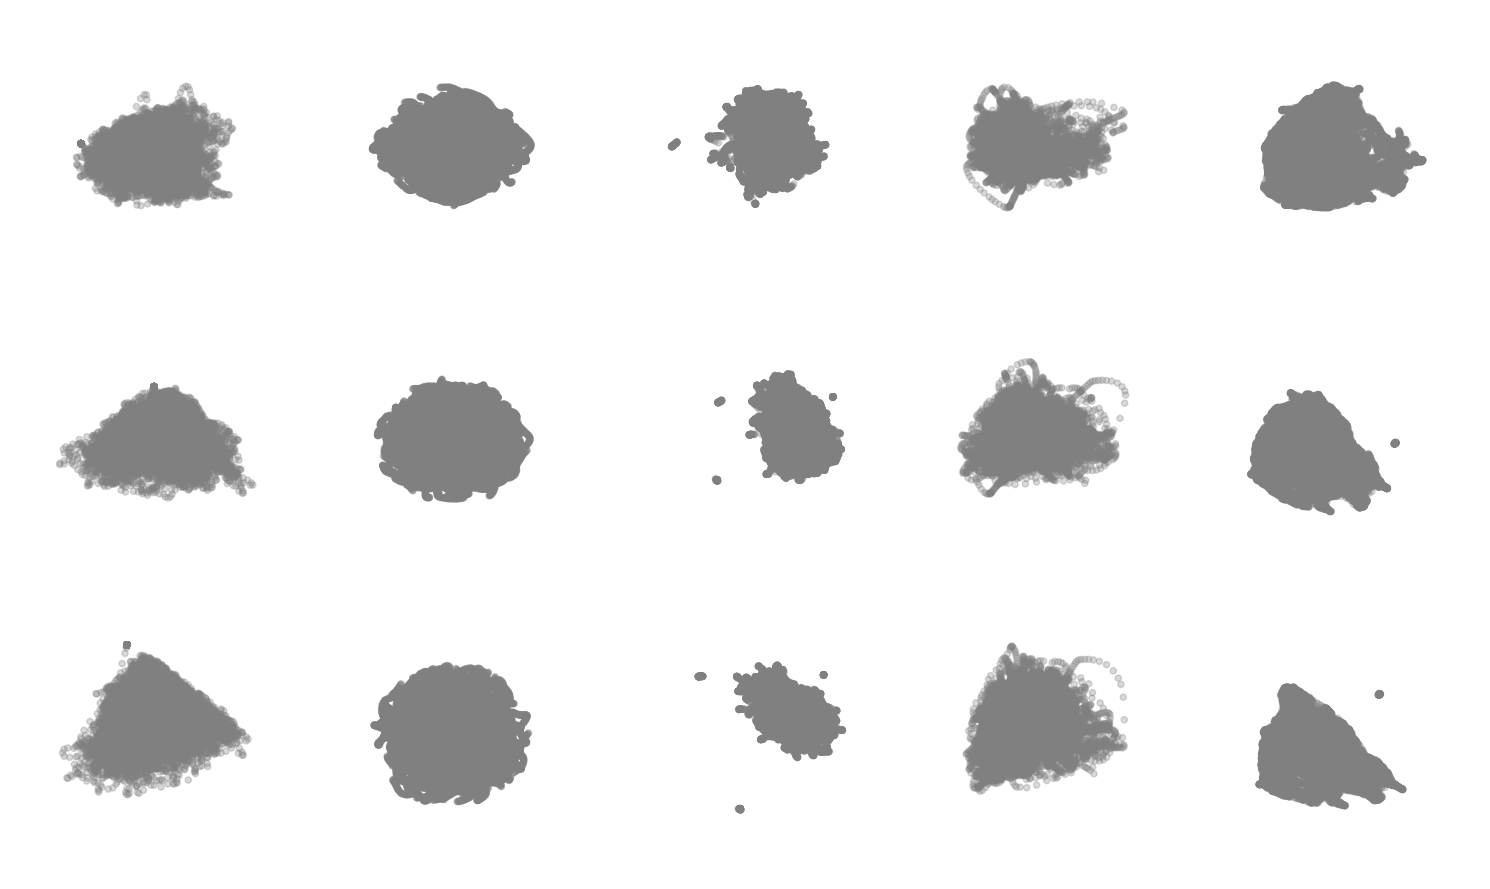

In [15]:
plot_dimensionality_reductions(spike_data=spike_data[spike_data["grid_score"] > 0.3], column="fr_time_binned_smoothed")
#plot_dimensionality_reductions(spike_data=spike_data[spike_data["grid_score"] > 0.3], column="ls_powers")